In [1]:
import pandas as pd


df = pd.read_csv("/home/nauel/vscode/EmbedDynamics/data_alt/04_create_metrics/df_1998-2024.csv", sep="|")

In [49]:
import numpy as np
import pandas as pd
import re

# Weighted median function (same as before)
def weighted_median(values, weights):
    sorter = np.argsort(values)
    values, weights = values[sorter], weights[sorter]
    cumsum = np.cumsum(weights)
    cutoff = weights.sum() / 2
    return values[np.searchsorted(cumsum, cutoff)]

# Step 1: seed words (max 3-4 per topic)
seed_words = {
    "interest_rates": ["interest", "policy", "rate"],
    "inflation": ["inflation", "price", "wage"],
    "employment": ["employment", "labor", "unemployment"],
    "financial_stability": ["prudential", "credit", "default"],
    "exchange_rates": ["exchange", "currency", "fx"],
    "commodities_energy": ["oil", "energy", "commodity"],
    "shocks_crisis": ["crisis", "liquidity", "stimulus"],
    "climate_green": ["climate", "emissions"]
}

# Step 2 & 3: Expand seed words with most_similar_cosine words

def expand_topic_words(df, seed_words, top_n=10):
    expanded = {}
    for topic, seeds in seed_words.items():
        words_set = set(seeds)
        for seed in seeds:
            row = df[df['word'] == seed]
            if row.empty or pd.isna(row.iloc[0]['most_similar_cosine']):
                continue
            similar = row.iloc[0]['most_similar_cosine']
            for item in similar[:top_n]:
                if isinstance(item, (list, tuple)) and len(item) == 2:
                    w, sim = item
                    words_set.add(w)
        expanded[topic] = words_set
    return expanded


expanded_topics = expand_topic_words(df, seed_words)

# Step 4 & 5: filter and compute weighted median distances

df_eu = df[df['region'] == 'EU']

years = sorted(df_eu['year'].dropna().unique())
result_df = pd.DataFrame(index=years)

for topic, words_set in expanded_topics.items():
    # Build regex pattern: escape words, join with |
    pattern = r"\b(" + "|".join(map(re.escape, words_set)) + r")\b"
    mask = df_eu['word'].str.contains(pattern, case=False, regex=True, na=False)
    topic_df = df_eu[mask]
    
    res = topic_df.groupby('year').apply(
        lambda g: weighted_median(g['distance_cosine'].values, g['norm'].values)
    )
    
    result_df[topic] = result_df.index.map(res.to_dict())

result_df.reset_index(names='year', inplace=True)


/tmp/ipykernel_1284910/3421142495.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_eu['word'].str.contains(pattern, case=False, regex=True, na=False)
/tmp/ipykernel_1284910/3421142495.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = topic_df.groupby('year').apply(
/tmp/ipykernel_1284910/3421142495.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_eu['word'].str.contains(pattern, case=False, regex=True, na=False)
/tmp/ipykernel_1284910/3421142495.py:59: FutureWarning: DataFrameGroupBy.apply 

In [122]:
import numpy as np
import pandas as pd
import re

# Weighted average with guard for empty arrays
def weighted_avg(values, weights):
    # Convert to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    
    # Mask to filter out NaNs in either values or weights
    mask = ~np.isnan(values) & ~np.isnan(weights)
    
    # Filtered arrays
    filtered_values = values[mask]
    filtered_weights = weights[mask]
    
    if len(filtered_values) == 0 or np.sum(filtered_weights) == 0:
        return np.nan
    
    return np.sum(filtered_values * filtered_weights) / np.sum(filtered_weights)

# Expanded seed words (you can tweak further)
seed_words = {
    "interest_rates": ["interest", "rate", "interest_rates"],
    "inflation": ["inflation", "price", "wage", "cpi"],
    "employment": ["employment", "labor", "unemployment"],
    "financial_stability": ["prudential", "credit", "liquidity"],
    # "exchange_rates": ["exchange", "currency", "trade"],
    # "commodities_energy": ["oil", "energy", "commodity"],
    "shocks_crisis": ["crisis", "stimulus", "pandemic"],
    "climate_green": ["climate", "green", "sustainable", "renewable"]
}


def expand_and_compute(df, seed_words, top_n=10, region='EU'):
    expanded_topics = {}
    
    for topic, seeds in seed_words.items():
        expanded_words = set(seeds)
        for seed in seeds:
            row = df[df['word'] == seed]
            if row.empty or pd.isna(row.iloc[0]['most_similar_cosine']):
                continue
            similar = row.iloc[0]['most_similar_cosine']
            if isinstance(similar, str):
                similar = eval(similar)
            for w, sim in similar[:top_n]:
                expanded_words.add(w)
        expanded_topics[topic] = expanded_words
    
    df_region = df[df['region'] == region].copy()
    result = {}

    for topic, words in expanded_topics.items():
        pattern = r"\b(?:" + "|".join(map(re.escape, words)) + r")\b"
        mask = df_region['word'].str.contains(pattern, case=False, regex=True, na=False)
        filtered = df_region[mask]
        if filtered.empty:
            continue
        grouped = filtered.groupby('year')[['distance_cosine', 'norm']].apply(
            lambda g: weighted_avg(g['distance_cosine'].values, g['norm'].values)
        )
        grouped = grouped.dropna()
        result[topic] = grouped
    
    result_df = pd.DataFrame(result)
    result_df.index.name = 'year'
    result_df.reset_index(inplace=True)
    return result_df


import seaborn as sns
import matplotlib.pyplot as plt

def plot_topic_distances_over_time(result_df):
    # Convert wide to long format for seaborn
    df_long = result_df.melt(id_vars='year', var_name='topic', value_name='weighted_median_distance')

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_long, x='year', y='weighted_median_distance', hue='topic')

    plt.xlabel('Year')
    plt.ylabel('Weighted Median Distance (cosine)')
    plt.title('Central Bank Topics – Distance Over Time (EU)')
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


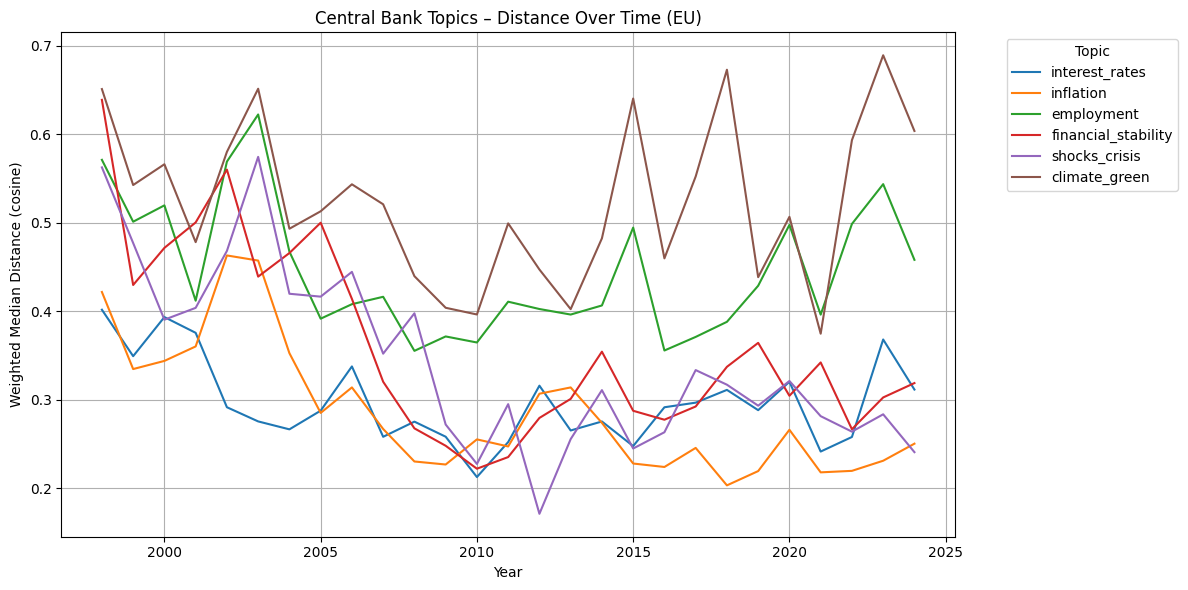

In [123]:
result_df = expand_and_compute(df, seed_words, top_n=1, region='EU')
plot_topic_distances_over_time(result_df)

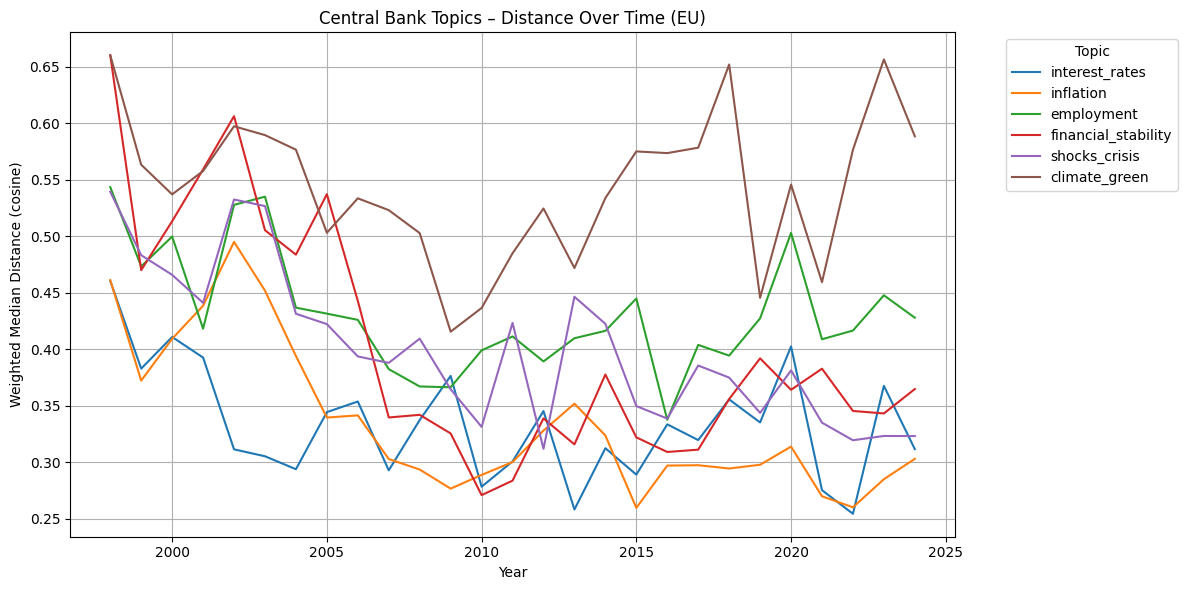

In [124]:
result_df = expand_and_compute(df, seed_words, top_n=3, region='EU')
plot_topic_distances_over_time(result_df)

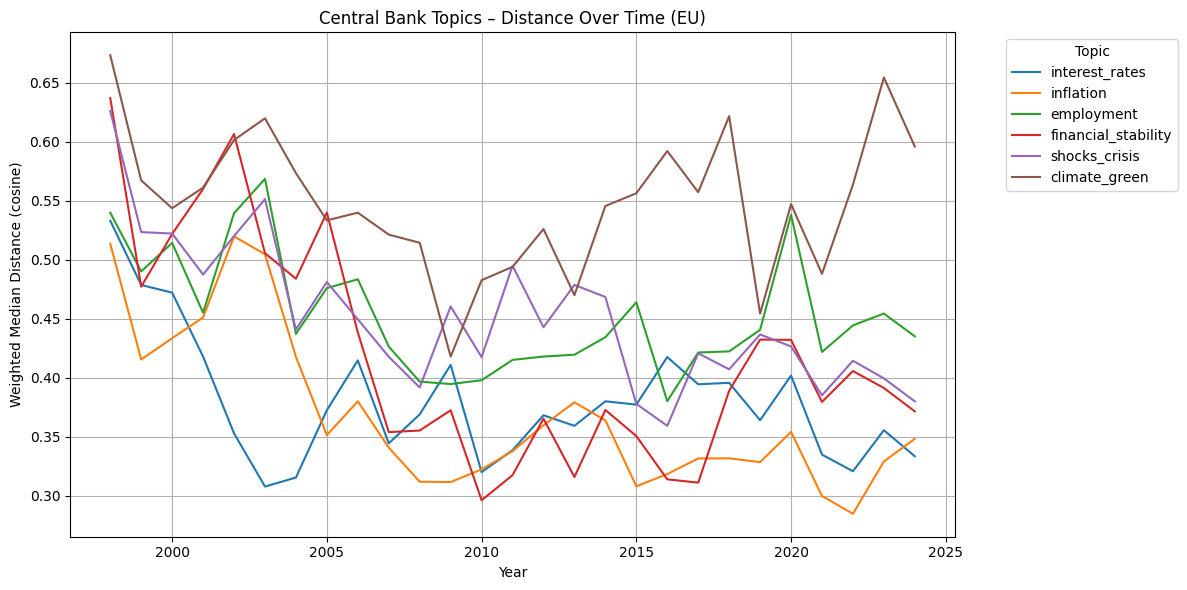

In [125]:
result_df = expand_and_compute(df, seed_words, top_n=5, region='EU')
plot_topic_distances_over_time(result_df)

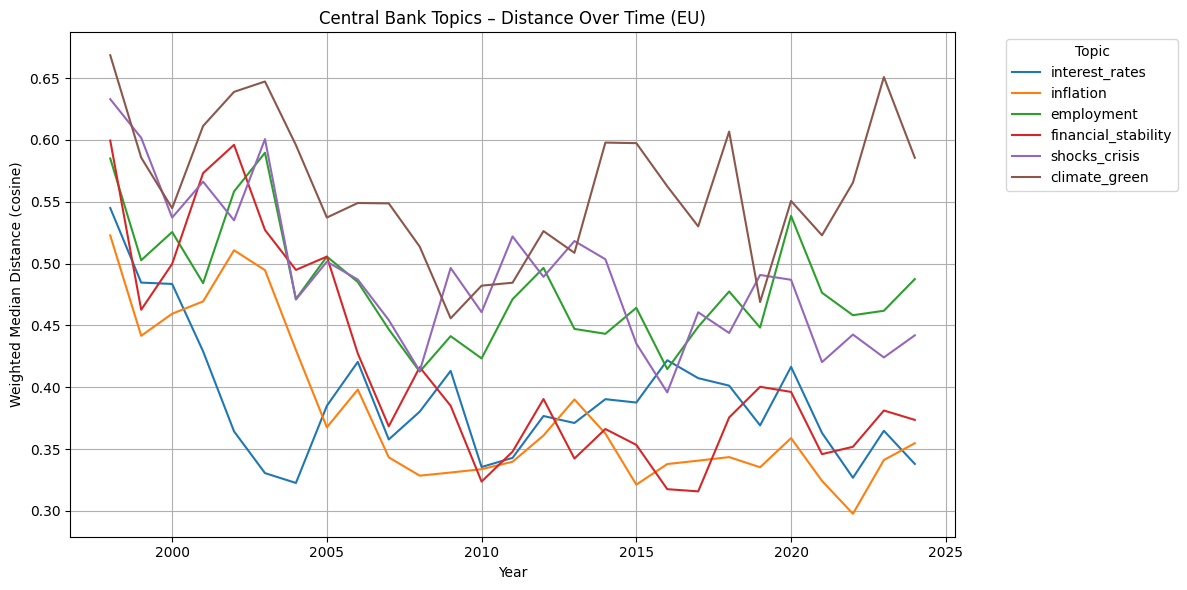

In [126]:
result_df = expand_and_compute(df, seed_words, top_n=7, region='EU')
plot_topic_distances_over_time(result_df)

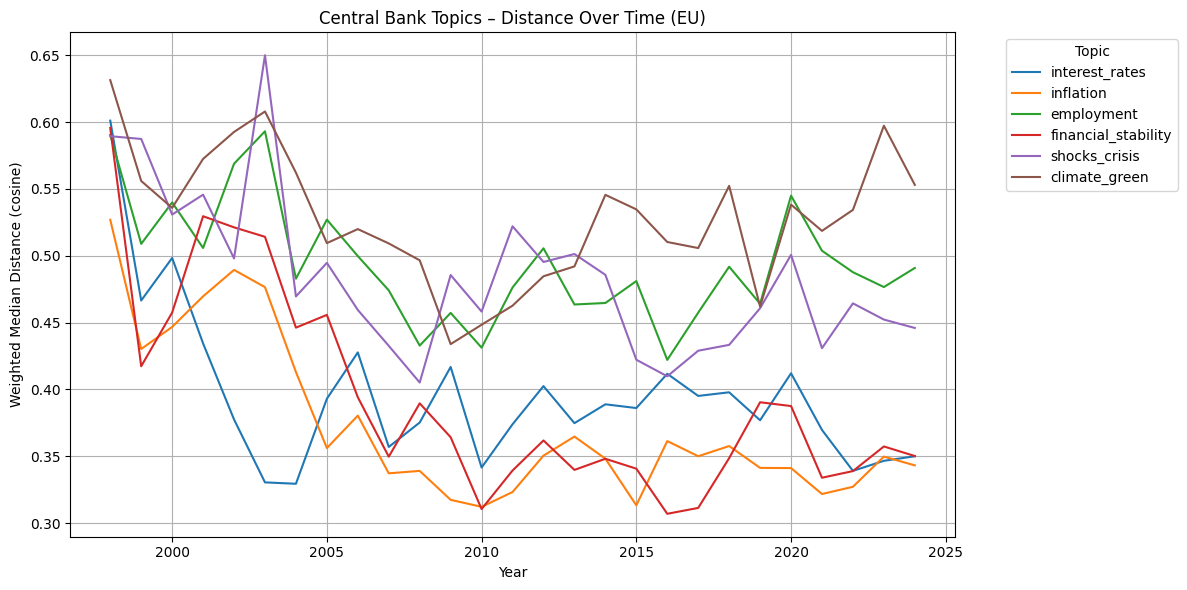

In [127]:
result_df = expand_and_compute(df, seed_words, top_n=8, region='EU')
plot_topic_distances_over_time(result_df)

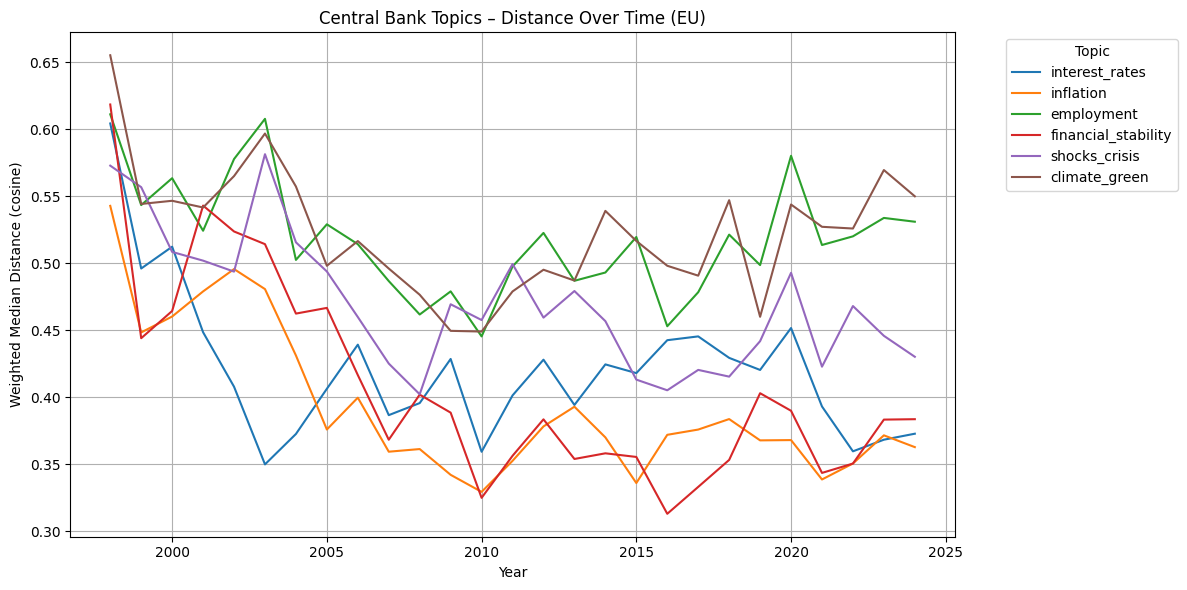

In [128]:
result_df = expand_and_compute(df, seed_words, top_n=10, region='EU')
plot_topic_distances_over_time(result_df)